In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
sys.path.append('..')
from tlfair.metrics import *
from tlfair.superlearner import *
from tlfair.knncmi import *

In [77]:
rng = np.random.default_rng()

n = 100000
cov = np.array(
    [[1,0,0,0,0],
    [0,1,0.5,0,0],
    [0,0.5,1,0,0],
    [0,0,0,1,-0.5],
    [0,0,0,-0.5,1]])
x = rng.multivariate_normal(mean=np.zeros(5), cov=cov, size=(n,))
g = (rng.uniform(size = (n,)) > 0.5).astype(np.int8)
beta0 = 0.5*np.ones(5)
beta1 = 2*np.ones(5)
y_probs = (1-g)*(1/(1+np.exp(x@beta0))) + g*(1/(1+np.exp(x@beta1)))
y = (y_probs > 0.5).astype(np.int8)

yx_model = LogisticRegression(solver='liblinear').fit(x, y)
yx_probs = yx_model.predict_proba(x)[:,1]

yx_model = LogisticRegression(solver='liblinear').fit(np.c_[x,g], y)
yx_probs = yx_model.predict_proba(np.c_[x,g])[:,1]

In [61]:
np.mean(y[g==1]) - np.mean(y[g==0])

0.0005640393099494156

In [78]:
np.mean(y_probs[np.intersect1d(np.where(g==1), np.where(y==1))]) - np.mean(y_probs[np.intersect1d(np.where(g==0), np.where(y==1))])

0.19261235285973144

In [79]:
np.mean(yx_probs[np.intersect1d(np.where(g==1), np.where(y==1))]) - np.mean(yx_probs[np.intersect1d(np.where(g==0), np.where(y==1))])

-0.0012428813841557362

In [39]:
r = 10000
xtr = x[:r,:]
ytr = y[:r]
gtr = g[:r]

xte = x[r:2*r,:]
yte = y[r:2*r]
gte = g[r:2*r]

outcome = LogisticRegression(solver='liblinear').fit(xtr, ytr)

yg1 = np.all(
    np.array([gte==1, yte==1]),
    axis = 0
    )
yg0 = np.all(
    np.array([gte==0, yte==1]),
    axis = 0
    )
phi0 = -1/np.mean(yg0) * outcome.predict(xte[np.where(yg0)[0],:])
phi1 = 1/np.mean(yg1) * outcome.predict(xte[np.where(yg1)[0],:])
phi = np.hstack([phi0, phi1])
est = np.sum(phi)/gte.shape[0]
eif = phi - est
ci = (est - 1.96*np.sqrt(np.var(eif)/len(gte)), est + 1.96*np.sqrt(np.var(eif)/len(gte)))

In [40]:
print(est)
print(ci)

-0.039877600166637876
(-0.10588049480666814, 0.026125294473392395)


In [32]:
yg_tr = np.zeros(shape=(len(gtr),)).astype(np.int8)
yg_tr[np.intersect1d(np.where(gtr==0), np.where(ytr==0))] = 0
yg_tr[np.intersect1d(np.where(gtr==1), np.where(ytr==0))] = 1
yg_tr[np.intersect1d(np.where(gtr==0), np.where(ytr==1))] = 2
yg_tr[np.intersect1d(np.where(gtr==1), np.where(ytr==1))] = 3

outcome = LogisticRegression(solver='liblinear').fit(xtr, ytr)
propensity = LogisticRegression(solver='liblinear').fit(xtr, yg_tr)

yg1 = np.all(
    np.array([gte==1, yte==1]),
    axis = 0
    )
yg0 = np.all(
    np.array([gte==0, yte==1]),
    axis = 0
    )
props = propensity.predict_proba(xte)
preds = outcome.predict_proba(xte)[:,1]
phi0 = -1/np.mean(yg0) * (props[:,2]*((yte==1) - preds) + yg0 * preds)
phi1 = 1/np.mean(yg1) * (props[:,3]* ((yte==1) - preds) + yg1 * preds)
phi = phi0 + phi1
est = np.mean(phi)
eif = est - phi
ci = (est - 1.96*np.sqrt(np.var(eif)/len(gte)), est + 1.96*np.sqrt(np.var(eif)/len(gte)))

In [33]:
print(est)
print(ci)

-0.0016755811437908121
(-0.048999100405519365, 0.045647938117937735)


In [52]:
def opportunity_sim(
    n,
    proportion = 0.5,
    estimand ='threshold',
    rng=None):

    if rng is None:
        rng = np.random.default_rng()

    n = n // 2 # sample splitting
    cov = np.array(
    [[1,0,0,0,0],
    [0,1,0.5,0,0],
    [0,0.5,1,0,0],
    [0,0,0,1,-0.5],
    [0,0,0,-0.5,1]])
    x = rng.multivariate_normal(mean=np.zeros(5), cov=cov, size=(2*n,))
    g = (rng.uniform(size = (2*n,)) > proportion).astype(np.int8)
    beta0 = 0.5*np.ones(5)
    beta1 = 2*np.ones(5)
    y_probs = (1-g)*(1/(1+np.exp(x@beta0))) + g*(1/(1+np.exp(x@beta1)))
    y = (y_probs > 0.5).astype(np.int8)

    yg = np.zeros(shape=(2*n,)).astype(np.int8)
    yg[np.intersect1d(np.where(g==0), np.where(y==0))] = 0
    yg[np.intersect1d(np.where(g==1), np.where(y==0))] = 1
    yg[np.intersect1d(np.where(g==0), np.where(y==1))] = 2
    yg[np.intersect1d(np.where(g==1), np.where(y==1))] = 3

    xtr, xte = x[:n,:], x[n:,:]
    ytr, yte = y[:n], y[n:]
    gtr, gte = g[:n], g[n:]
    yg_tr = yg[:n]

    yg1 = np.all(
        np.array([gte==1, yte==1]),
        axis = 0
        )
    yg0 = np.all(
        np.array([gte==0, yte==1]),
        axis = 0
        )

    model = LogisticRegression(solver='liblinear').fit(xtr, ytr)
    propensity = LogisticRegression(solver='liblinear').fit(xtr, yg_tr)

    if estimand == 'threshold':
        preds = model.predict(xte)
        phi0 = -1/np.mean(yg0) * preds[np.where(yg0)[0]]
        phi1 = 1/np.mean(yg1) * preds[np.where(yg1)[0]]
        phi = np.hstack([phi0, phi1])
        est = np.sum(phi)/gte.shape[0]
        eif = phi - est
        var = np.var(eif)/n
        naive_est = np.mean(preds[np.where(yg1)[0]])- np.mean(preds[np.where(yg0)[0]])
        naive_var = (np.var(preds[np.where(yg1)[0]]) + np.var(preds[np.where(yg0)[0]]))/n
        error = np.mean(np.abs(preds - yte))

    if estimand == 'prob':
        props = propensity.predict_proba(xte)
        preds = model.predict_proba(xte)[:,1]
        phi0 = -1/np.mean(yg0) * (props[:,2]*((yte==1) - preds) + yg0 * preds)
        phi1 = 1/np.mean(yg1) * (props[:,3]* ((yte==1) - preds) + yg1 * preds)
        phi = phi0 + phi1
        est = np.mean(phi)
        eif = est - phi
        var = np.var(eif)/n
        naive_est = np.mean(preds[np.where(yg1)[0]])- np.mean(preds[np.where(yg0)[0]])
        naive_var = (np.var(preds[np.where(yg1)[0]]) + np.var(preds[np.where(yg0)[0]]))/n
        error = np.mean(np.abs(preds - yte))

    return est, var, naive_est, naive_var

In [53]:
def coverage_sim_opp(
    n,
    n_sims = 100,
    estimand = 'threshold'):

    rng = np.random.default_rng()

    coverage = 0

    for _ in range(n_sims):
        res = opportunity_sim(
            n = n,
            estimand=estimand,
            rng=rng
        )
        est = res[0]
        var = res[1]
        upper = est + 1.96*np.sqrt(var)
        lower = est - 1.96*np.sqrt(var)
        if (upper >= 0) and (lower <= 0):
            coverage += 1
    return coverage/n_sims 

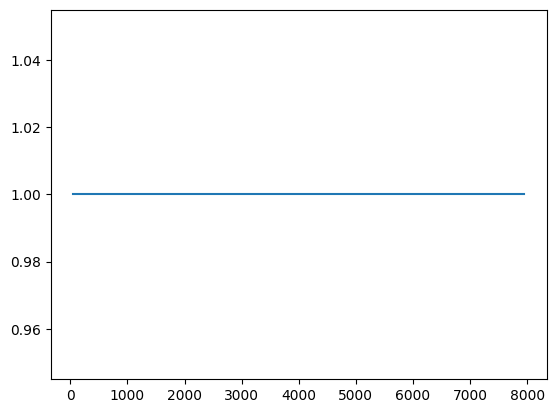

In [71]:
sample_sizes = np.round(np.power(10, np.arange(1.7, 4, 0.1))).astype(np.int64)
coverage = []
for size in sample_sizes:
    res = coverage_sim_opp(
        n_sims = 100,
        n = size,
        estimand='prob'
    )
    coverage.append(res)
plt.plot(sample_sizes, coverage)

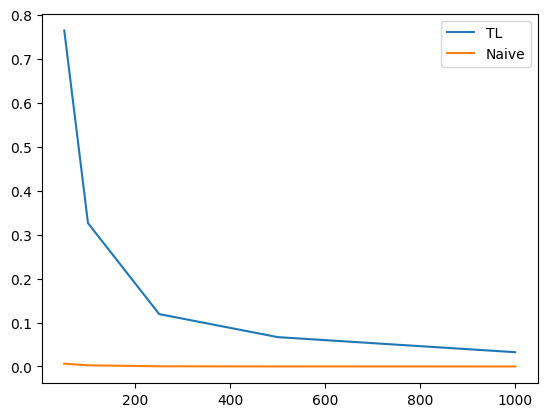

In [63]:
reps = 10
sizes = [50, 100, 250, 500, 1000]
tl = []
naive = []

for i in range(len(sizes)):
    tl_res = 0
    naive_res = 0
    for _ in range(reps):
        res = opportunity_sim(
            n = sizes[i],
            estimand = 'threshold'
            )
        tl_res += res[1]
        naive_res += res[3]
    tl.append(tl_res/reps)
    naive.append(naive_res/reps)

plt.plot(sizes, tl, label="TL")
plt.plot(sizes, naive, label="Naive")
plt.legend()